# AMS Solar Energy Prediction

https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest/data

> The goal of this contest is to discover which statistical and machine learning techniques provide the best short term predictions of solar energy production. Contestants will predict the total daily incoming solar energy at 98 Oklahoma Mesonet sites, which will serve as "solar farms" for the contest. Input numerical weather prediction data for the contest comes from the NOAA/ESRL Global Ensemble Forecast System (GEFS) Reforecast Version 2. Data include all 11 ensemble members and the forecast timesteps 12, 15, 18, 21, and 24. Locations of the Mesonet sites relative to the GEFS data are shown in the above figure. Training data will come from 1994-2007. Public testing data will be from 2008-2009. Private testing data for a more recent period will be used for the final evaluation.

> Contestants will submit predictions of the total solar daily incoming solar radiation at 98 Oklahoma Mesonet sites for each day specified in the test.csv file. The Mean Absolute Error (MAE) is the metric being used for this competition.

In [78]:
import os

from netCDF4 import Dataset
import numpy as np
import scipy as sp
import pandas as pd
import pandas_profiling
from sklearn_pandas import DataFrameMapper
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from yellowbrick.regressor import PredictionError
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

## Trivial Model

In [29]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(5113, 99)


,Date,ACME,ADAX,ALTU,APAC,ARNE,BEAV,BESS,BIXB,BLAC,...,VINI,WASH,WATO,WAUR,WEAT,WEST,WILB,WIST,WOOD,WYNO
0,19940101,12384900,11930700,12116700,12301200,10706100,10116900,11487900,11182800,10848300,...,10771800,12116400,11308800,12361800,11331600,10644300,11715600,11241000,10490100,10545300
1,19940102,11908500,9778500,10862700,11666400,8062500,9262800,9235200,3963300,3318300,...,4314300,10733400,9154800,12041400,9168300,4082700,9228000,5829900,7412100,3345300
2,19940103,12470700,9771900,12627300,12782700,11618400,10789800,11895900,4512600,5266500,...,2976900,11775000,10700400,12687300,11324400,2746500,3686700,4488900,9712200,4442100
3,19940104,12725400,6466800,13065300,12817500,12134400,11816700,12186600,3212700,8270100,...,3476400,12159600,11907000,12953100,11903700,2741400,4905000,4089300,11401500,4365000
4,19940105,10894800,11545200,8060400,10379400,6918600,9936300,6411300,9566100,8009400,...,6393300,11419500,7334400,10178700,7471500,8235300,11159100,10651500,10006200,8568300


In [ ]:
%%time
train.profile_report()

In [42]:
dataset = train[['Date', 'ACME']].copy()
dataset['ACME_s1'] = dataset.ACME.shift()
dataset.dropna(inplace=True)
dataset.head()

,Date,ACME,ACME_s1
1,19940102,11908500,12384900.0
2,19940103,12470700,11908500.0
3,19940104,12725400,12470700.0
4,19940105,10894800,12725400.0
5,19940106,6639000,10894800.0


In [44]:
X = dataset[['ACME_s1']]
y = dataset.ACME

In [72]:
def fit_evaluate(pipeline, X, y):
    scores = cross_validate(
        pipeline, 
        X, y, 
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
        cv=3, 
        n_jobs=-1
    )
    print(f'MAE: {scores["test_neg_mean_absolute_error"].mean()*-1:.3f} {np.round(scores["test_neg_mean_absolute_error"]*-1, 3)}')          
    print(f'MSE: {scores["test_neg_mean_squared_error"].mean()*-1:.3f} {np.round(scores["test_neg_mean_squared_error"]*-1, 3)}')
    print(f'R^2: {scores["test_r2"].mean()*-1:.3f} {np.round(scores["test_r2"]*-1, 3)}')
    print()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    fig, ax = plt.subplots(figsize=(7, 7))
    visualizer = PredictionError(pipeline, ax=ax)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    if isinstance(pipeline, Pipeline) and hasattr(pipeline.steps[-1][1], 'feature_importances_'):
        feature_importances = pd.DataFrame({'name': mapper.transformed_names_, 'importance': pipeline[-1].feature_importances_})
        feature_importances.sort_values(by='importance', ascending=False, inplace=True)
        print(feature_importances)
          
    return pipeline

MAE: 6713730.993 [6827760.853 6843875.884 6469556.24 ]
MSE: 61962300041932.773 [6.33898044e+13 6.44180151e+13 5.80790806e+13]
R^2: 0.001 [0.002 0.    0.001]



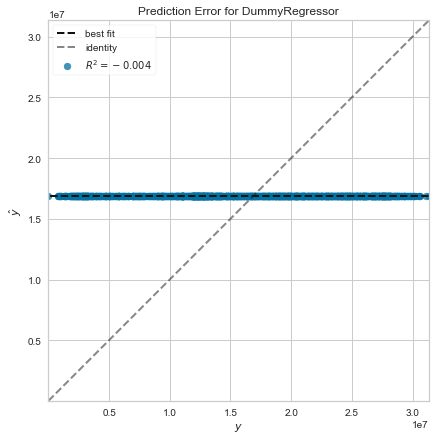

In [73]:
pipeline = make_pipeline(
    DummyRegressor()
)
pipeline = fit_evaluate(reg, X, y)

In [ ]:
pipeline = make_pipeline(
    DummyRegressor()
)
pipeline = fit_evaluate(reg, X, y)

MAE: 6713730.993 [6827760.853 6843875.884 6469556.24 ]
MSE: 61962300041932.773 [6.33898044e+13 6.44180151e+13 5.80790806e+13]
R^2: 0.001 [0.002 0.    0.001]



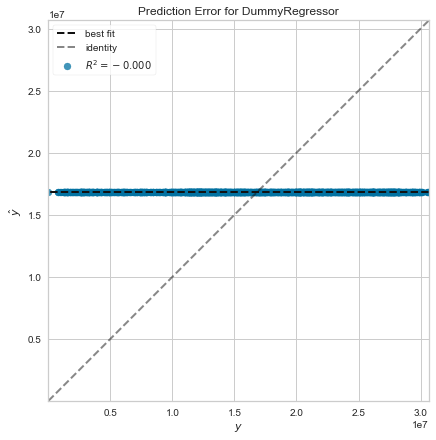

In [77]:
pipeline = make_pipeline(
    LinearRegression()
)
pipeline = fit_evaluate(reg, X, y)

In [23]:
apcp = Dataset('train/apcp_sfc_latlon_subset_19940101_20071231.nc')

In [25]:
apcp.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     long_name: Time
     units: hours since 1800-01-01 00:00:00
     axis: T
 unlimited dimensions: 
 current shape = (5113,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'intTime': <class 'netCDF4._netCDF4.Variable'>
 int32 intTime(time)
     long_name: time as an integer (YYYYMMDDHH)
 unlimited dimensions: 
 current shape = (5113,)
 filling on, default _FillValue of -2147483647 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float32 lat(lat)
     long_name: Latitude
     standard_name: latitude
     units: degrees_north
     actual_range: [31. 39.]
     axis: Y
 unlimited dimensions: 
 current shape = (9,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float32 lon(lon)
     long_name: Longitude
     standard_name: longitude
     units: degrees_east
     actual_range: [254. 269.]
     axis: X
 unlimited dimensions: 
 current shape = (16,)

In [24]:
apcp.dimensions

{'time': <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 5113,
 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9,
 'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16,
 'ens': <class 'netCDF4._netCDF4.Dimension'>: name = 'ens', size = 11,
 'fhour': <class 'netCDF4._netCDF4.Dimension'>: name = 'fhour', size = 5}

In [17]:
dataset = Dataset('gefs_elevations.nc')

In [21]:
dataset.dimensions

{'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16,
 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9}

In [19]:
dataset.variables

{'elevation_control': <class 'netCDF4._netCDF4.Variable'>
 float32 elevation_control(lat, lon)
     units: m
 unlimited dimensions: 
 current shape = (9, 16)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'elevation_perturbation': <class 'netCDF4._netCDF4.Variable'>
 float32 elevation_perturbation(lat, lon)
     units: m
 unlimited dimensions: 
 current shape = (9, 16)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(lat, lon)
 unlimited dimensions: 
 current shape = (9, 16)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(lat, lon)
 unlimited dimensions: 
 current shape = (9, 16)
 filling on, default _FillValue of 9.969209968386869e+36 used}

In [18]:
dir(dataset)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__orthogonal_indexing__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_close',
 '_close_mem',
 '_enddef',
 '_grpid',
 '_isopen',
 '_ncstring_attrs__',
 '_redef',
 'close',
 'cmptypes',
 'createCompoundType',
 'createDimension',
 'createEnumType',
 'createGroup',
 'createVLType',
 'createVariable',
 'data_model',
 'delncattr',
 'dimensions',
 'disk_format',
 'enumtypes',
 'file_format',
 'filepath',
 'get_variables_by_attributes',
 'getncattr',
 'groups',
 'isopen',
 'keepweakref',
 'ncattrs',
 'parent',
 'path',
 'renameAttribute',
 'renameDimension',
 'renameGroup',
 'renameVariable',
 'set_always_mask',
 'set_auto_chartostring',
